/opt/anaconda3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)
/opt/anaconda3/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


KeyError: "'blue' is not a known colormap name"

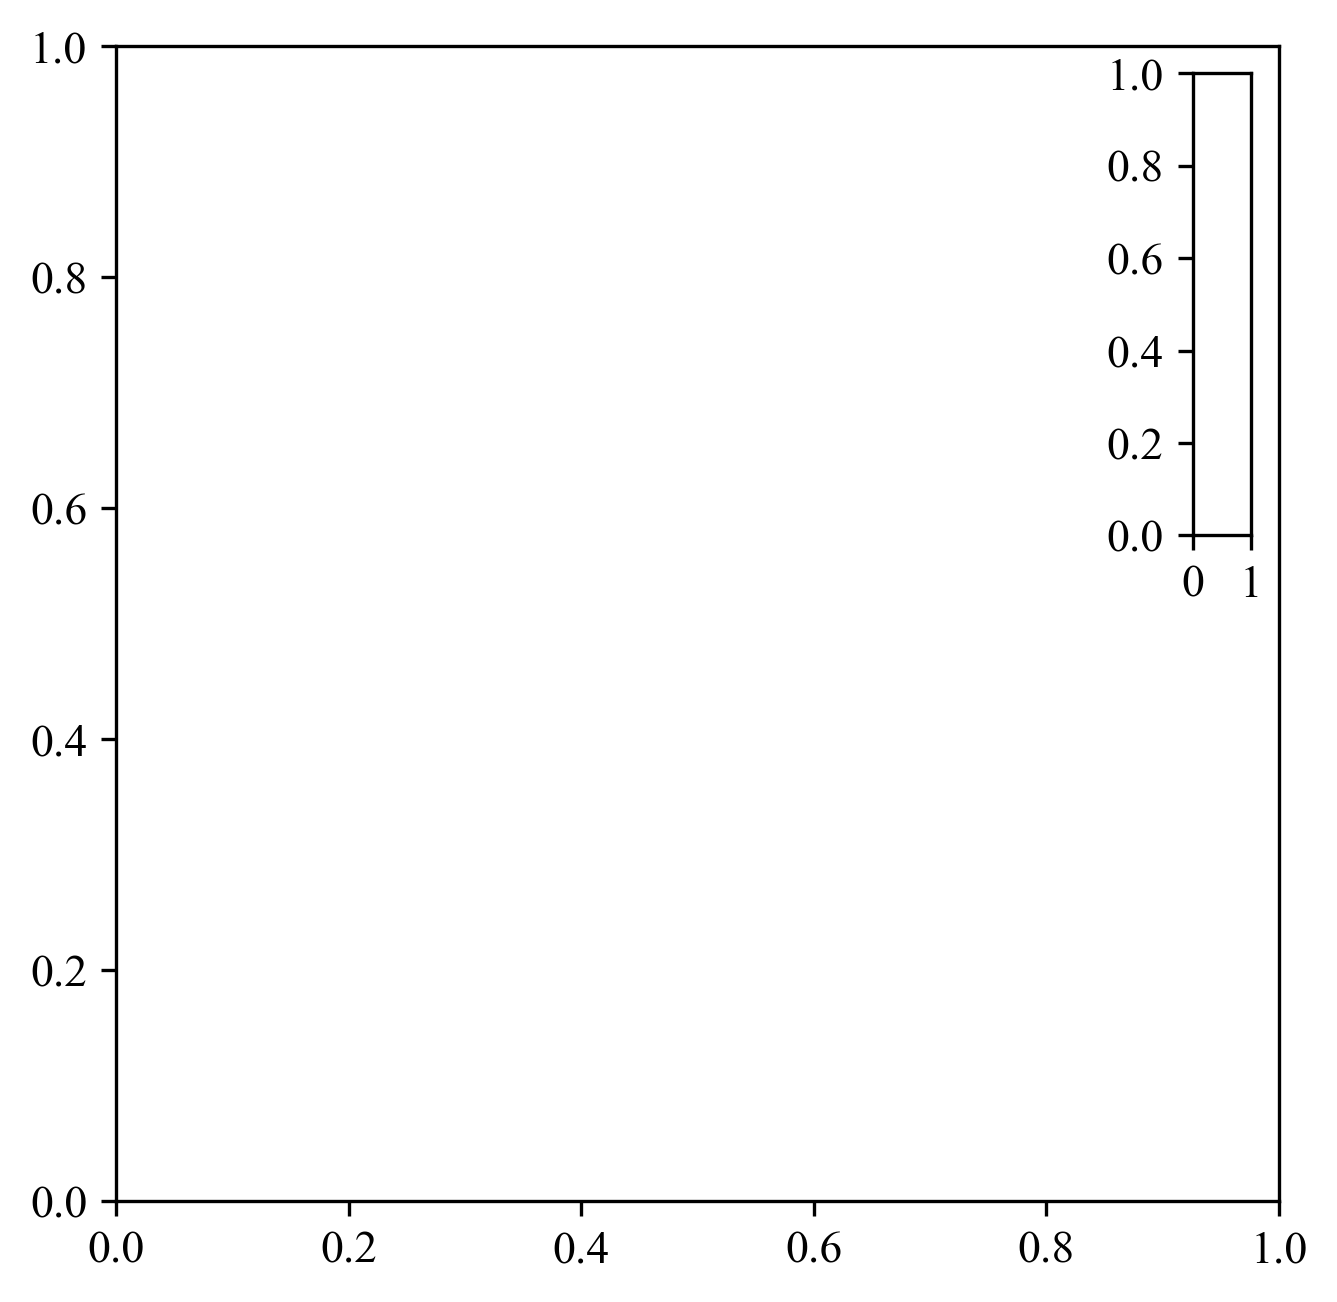

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import csv

path = "/Users/stevenchristian/bch709_vibe_coding/data/gasch2000.txt"
if not os.path.exists(path):
    raise FileNotFoundError(f"File not found: {path}")

# Detect delimiter
with open(path, "r", encoding="utf-8", errors="ignore") as f:
    sample = f.read(4096)
    f.seek(0)
    try:
        dialect = csv.Sniffer().sniff(sample, delimiters=[",", "\t", ";", " "])
        sep = dialect.delimiter
    except Exception:
        sep = "\t"
df = pd.read_csv(path, sep=sep)

# Assume first column is gene ID/name
gene_col = df.columns[0]

# Get numeric columns (conditions)
num_df = df.select_dtypes(include=[np.number]).copy()
if num_df.empty:
    num_df = df.drop(columns=[gene_col]).apply(pd.to_numeric, errors="coerce")
num_df = num_df.dropna(axis=1, how="all")

# CV = std / mean
means = num_df.mean(axis=1)
stds = num_df.std(axis=1, ddof=1)
cv = stds / means.replace(0, np.nan)
top_idx = cv.nlargest(10).index

top_genes = df.loc[top_idx, gene_col].astype(str).values
top_vals = num_df.loc[top_idx]

# Log scale (log2(x+1) to handle zeros)
log_vals = np.log2(top_vals + 1)

# Heatmap matrix: rows=conditions, cols=genes
heat = log_vals.T
heat.columns = top_genes
heat.index = top_vals.columns.astype(str)

# Styling
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.size"] = 11

fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

# Legend (colorbar) top right
cax = inset_axes(ax, width="5%", height="40%", loc="upper right", borderpad=0.6)

sns.heatmap(
    heat,
    ax=ax,
    cmap="PuGn",
    cbar=True,
    cbar_ax=cax,
    linewidths=0
)

ax.set_title("Gene Heatmap")
ax.set_xlabel("gene")
ax.set_ylabel("conditions")

# Black border around heatmap
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color("black")
    spine.set_linewidth(1)

plt.tight_layout()
plt.show()


Save

In [ ]:
plt.savefig("gene_heatmap.png", dpi=300, bbox_inches="tight", facecolor="white")
